# Interpolating ERA5, NSIDC, and IBCAO data to buoy positions


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pyproj

In [17]:
# load data
import os
import sys
# Add the path to icedrift package
sys.path.append("\\Users\danie\Documents\Research\icedrift\src")
from icedrift.interpolation import interpolate_buoy_track
from icedrift.cleaning import standard_qc

dataloc = "../data/buoy_data/cirfa2022/"
saveloc = "../data/buoy_data_interpolated/cirfa22/"


In [3]:
buoy_data = {}
for f in os.listdir(dataloc):
    if 'csv' in f:
        buoy_df = pd.read_csv(dataloc + f, parse_dates=True, index_col=0) 
        buoy_df["timestamp"] = buoy_df.index
        
        df_qc = standard_qc(buoy_df,
                            min_size=100,
                            gap_threshold='6h',                
                            segment_length=24,
                            lon_range=(-180, 180),
                            lat_range=(65, 90),
                            max_speed=1.5,
                            speed_window='3D',
                            verbose=False)
        
        # Interpolate to hourly
        if df_qc is not None:
            df_interp = interpolate_buoy_track(df_qc.where(~df_qc.flag).dropna(), maxgap_minutes=240, freq='1h')
        
            buoy_data[f.replace('.csv', '')] = df_interp.loc[:, ['longitude', 'latitude']]

In [4]:
# SIC data from NSIDC
sic_data = xr.open_dataset('../data/nsidc_daily_sic_cdr_2022.nc')
# Reformat NSIDC data for convenience with interpolation -- essentially renaming coordinates and dimensions
ds_sic = xr.Dataset({'sea_ice_concentration': (('time', 'y', 'x'), sic_data['cdr_seaice_conc'].data)},
           coords={'time': ('time', pd.to_datetime(sic_data.time.data)),
                   'x': ('x', sic_data['xgrid'].data),
                   'y': ('y', sic_data['ygrid'].data)
                 })

In [5]:
def sic_along_track(position_data, sic_data):
    """Uses the xarray advanced interpolation to get along-track sic
    via nearest neighbors."""
    # Sea ice concentration uses NSIDC NP Stereographic
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs')
    transformer_stere = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
    
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    for date, group in position_data.groupby(position_data.index):
        x_stere, y_stere = transformer_stere.transform(
            group.longitude, group.latitude)
        
        x = xr.DataArray(x_stere, dims="z")
        y = xr.DataArray(y_stere, dims="z")
        SIC = sic_data.sel(time=date.strftime('%Y-%m-%d'))['sea_ice_concentration'].interp(
            {'x': x,
             'y': y}, method='nearest').data

        sic.loc[group.index] = np.round(SIC.T, 3)
    return sic

In [6]:
last_dates = {}
for buoy in buoy_data:
    # Get the SIC for the daily mean position
    sic = sic_along_track(buoy_data[buoy].resample('1D').mean(), ds_sic)

    # Forward-fill to extend to the hourly data
    buoy_data[buoy] = buoy_data[buoy].merge(pd.DataFrame({'sea_ice_concentration': sic}), left_index=True, right_index=True, how='outer')
    buoy_data[buoy]['sea_ice_concentration'] =  buoy_data[buoy]['sea_ice_concentration'].ffill()
    buoy_data[buoy].dropna(subset='longitude', inplace=True)

    # Use the latest date with n
    last_date = sic[(sic <= 1) & (sic >= 0.15)].index.max()
    buoy_data[buoy]['ice_flag'] = 0
    buoy_data[buoy].loc[last_date:, 'ice_flag'] = 1

C:\Users\danie\.conda\envs\ift_annals\lib\site-packages\pyproj\transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
C:\Users\danie\.conda\envs\ift_annals\lib\site-packages\xarray\core\missing.py:562: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
C:\Users\danie\.conda\envs\ift_annals\lib\site-packages\xarray\core\missing.py:563: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
C:\Users\danie\.conda\envs\ift_annals\lib\site-packages\pyproj\transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
C:\Users\danie\.conda\envs\ift_annals\lib\site-packages\pyproj\transformer.py:820: FutureWarning: Calling float on a single element Seri

In [7]:
depth = xr.open_dataset('../data/interpolated_depth.nc')

C:\Users\danie\.conda\envs\ift_annals\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


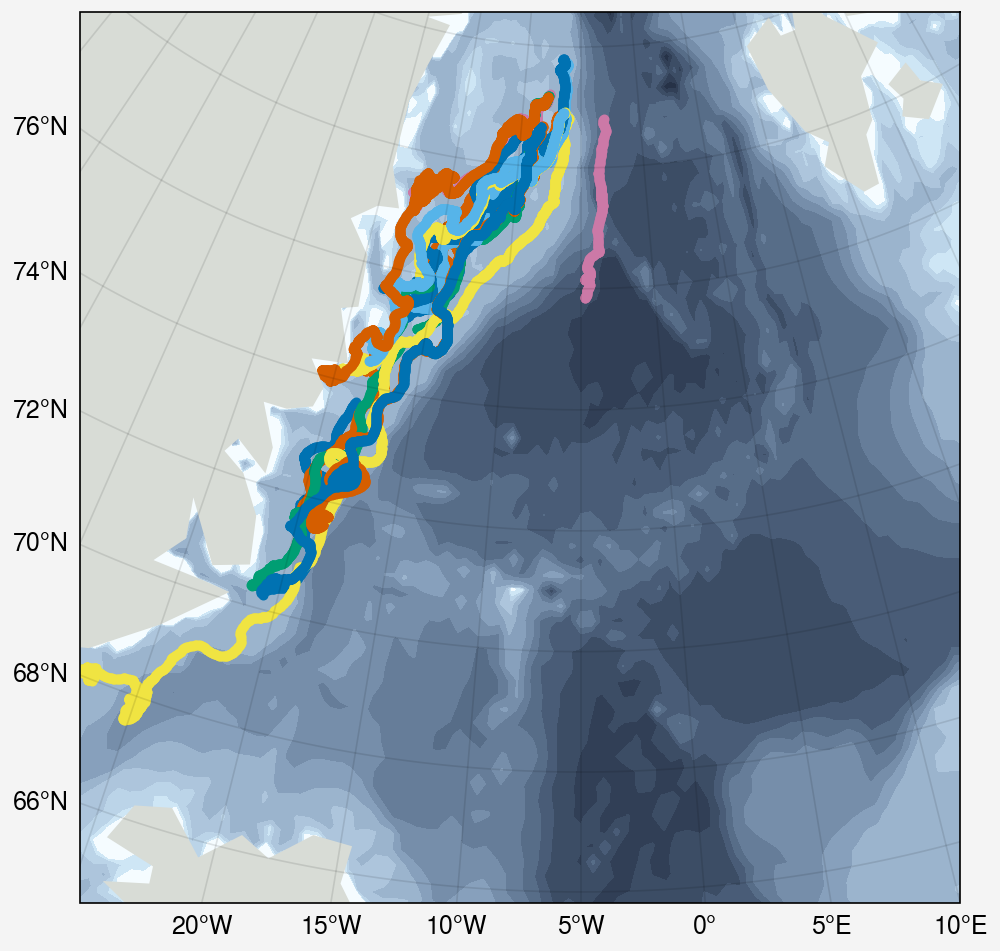

In [9]:
import proplot as pplt
fig, ax = pplt.subplots(proj='ortho', proj_kw={'lon_0': -5, 'lat_0': 75}, width=5)
ax.format(latlim=(65, 80), lonlim=(-25,10),  land=True,
          landcolor='light gray', latlabels=True, lonlabels=True)
cbar = ax.contourf(depth.longitude,
                depth.latitude,
                depth.z, levels=[-4000, -3500, -3000, -2500,
                              -2000, -1500, -1000, -500,
                              -200, -100, -50, 0],
                cmap='blues8_r',
                extend='both')
for b in buoy_data:
    ax.scatter(buoy_data[b].loc[buoy_data[b].ice_flag != 1, 'longitude'].values,
            buoy_data[b].loc[buoy_data[b].ice_flag != 1, 'latitude'].values,
               # c = buoy_data[b].loc[buoy_data[b].ice_flag != 1, 'sea_ice_concentration'].values, cmap='bwr', vmin=0, vmax=2.54,
               marker='.')

In [10]:

def era5_along_track(position_data, era_data, variables=['u10', 'v10', 'msl']):
    """Uses the xarray advanced interpolation to get along-track era5 winds.
    Uses nearest neighbor for now for speed."""
    
    df = pd.DataFrame(data=np.nan, index=position_data.index, columns=variables)
    
    for date, group in position_data.groupby(position_data.datetime):
        
        x = xr.DataArray(group.longitude, dims="z")
        y = xr.DataArray(group.latitude, dims="z")
        for var in variables:
            X = era_data.sel(valid_time=date)[var].interp(
                    {'longitude': x,
                     'latitude': y}, method='nearest').data
            df.loc[group.index, var] = np.round(X.T, 3)
    return df

In [11]:
era5 = xr.open_dataset('../data/era5_cirfa2022.nc')

In [ ]:
# Started at 5:07

In [ ]:
%%time
min_time = '2022-05-01'
max_time = '2022-09-30'
for buoy in buoy_data:
    buoy_data[buoy]['buoy_id'] = buoy
    
all_data = pd.concat([buoy_data[b].loc[slice(min_time, max_time)].reset_index() for b in buoy_data]).reset_index(drop=True)

test = era5_along_track(all_data, era5)

In [ ]:
all_data = pd.concat([all_data, test], axis=1)

In [ ]:
# unpack the dataset
for buoy, group in all_data.groupby('buoy_id'):
    for var, longname in zip(['u10', 'v10', 'msl'], ['u_wind', 'v_wind', 'slp']):
        buoy_data[buoy].loc[group['datetime'], longname] = group[var].values
    buoy_data[buoy]['slp'] = (buoy_data[buoy]['slp']/100).round(1)
    buoy_data[buoy].to_csv(saveloc + buoy + '.csv')

In [170]:
era5.close()

In [164]:
def depth_along_track(position_data, depth_data):
    """Uses the xarray advanced interpolation to get along-track depth
    via nearest neighbor interpolation."""

    # Transform lon/lat to IBCAO x/y
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('epsg:3996') # IBCAO Polar Stereographic
    lon = position_data.longitude
    lat = position_data.latitude

    z_grid = np.zeros(lon.shape)

    transformer_ll2ps = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)

    x_grid, y_grid = transformer_ll2ps.transform(lon, lat)

    ds_sel = depth_data.sel(x=slice(np.nanmin(x_grid), np.nanmax(x_grid)),
                          y=slice(np.nanmin(y_grid), np.nanmax(y_grid)))

    x = np.array(ds_sel.x.data).astype(float)
    y = np.array(ds_sel.y.data).astype(float)       

    x_grid = xr.DataArray(x_grid, dims=('time'))
    y_grid = xr.DataArray(y_grid, dims=('time'))

    z_interp = ds_sel['z'].astype(np.float64).interp({'x': x_grid, 'y': y_grid}, method='linear')
    return z_interp.data

In [166]:
depth_along_track(buoy_data[buoy], depth)

KeyError: "'x' is not a valid dimension or coordinate"

In [167]:
depth

<xarray.Dataset>
Dimensions:    (latitude: 132, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 55.0 55.25 55.5 55.75 ... 87.25 87.5 87.75
  * longitude  (longitude) float64 -80.0 -79.5 -79.0 -78.5 ... 78.5 79.0 79.5
Data variables:
    z          (latitude, longitude) float64 ...